In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import time
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from senet import SENet18

In [2]:
PATH='/data/cifar10_kaggle/'
suffix='.png'

In [3]:
os.listdir(PATH)

['test',
 'test.7z',
 'trainLabels.csv',
 'sampleSubmission.csv',
 'sub',
 'weights',
 'train.7z',
 'train']

In [4]:
labels = pd.read_csv(f'{PATH}trainLabels.csv')
classes = sorted(list(set(labels['label'].tolist()))); classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
# Pre-calculated
mean, std = np.array([0.49139977, 0.4821584 , 0.4465309]), np.array([0.24703224, 0.24348513, 0.26158784])

# Explore Data

In [7]:
len(os.listdir(f'{PATH}train')), len(labels)

(50000, 50000)

In [8]:
labels.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)
selected_label_list = list(labels.groupby('label').count().sort_values(by='id', ascending=False).head(num_classes).index)

In [11]:
selected_label_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
labels = labels[labels['label'].isin(selected_label_list)]

In [13]:
labels['target'] = 1

In [14]:
labels['rank'] = labels.groupby('label').rank()['id']

In [15]:
labels_pivot = labels.pivot('id', 'label', 'target').reset_index().fillna(0)

In [16]:
train = labels_pivot.sample(frac=0.8)

In [17]:
labels_pivot.head()

label,id,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
labels_pivot.iloc[3, 1:].as_matrix().astype('float'), np.argmax(labels_pivot.iloc[3, 1:].as_matrix().astype('float'))

(array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 4)

In [20]:
image_name = f'{PATH}train/{labels.iloc[12, 0]}{suffix}'

In [21]:
image_name

'/data/cifar10_kaggle/train/13.png'

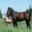

In [22]:
image = PIL.Image.open(image_name); image

# Define CIFAR10 Dataset

In [6]:
class CIFARDataset(Dataset):
    def __init__(self, labels, data_dir, transform=None):
        self.labels = labels
        self.data_dir = data_dir
        self.transform = transform
        classes = sorted(list(set(labels['label'].tolist())));
        self.class2idx = {k:i for i, k in enumerate(classes)}
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = f'{self.data_dir}/{self.labels.iloc[idx, 0]}{suffix}'
        image = PIL.Image.open(image_path)
        labels = self.class2idx[self.labels.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return [image, labels]
           

# Find dataset mean/std

In [6]:
train_ds = CIFARDataset(labels, f'{PATH}train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=4)

In [7]:
def getMeanStd(dataset, sz, bs):
    dl = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=4)
    itr = iter(dl)
    sum = 0
    for X,Y in itr:
        sum = sum + np.sum(X.numpy(), axis=(0,2,3))
    mean = sum / (sz*sz*len(dataset))
    std_sum = 0;
    for X,Y in iter(dl):
        xt = np.transpose(X.numpy(), axes=(0,2,3,1));
        std_sum = std_sum + np.sum((xt-mean)**2, axis=(0,1,2))
    std = np.sqrt(std_sum / (sz*sz*len(dataset)))
    return mean, std

In [8]:
mean, std = getMeanStd(train_ds, 32, 100); mean, std

(array([0.49139977, 0.4821584 , 0.4465309 ]),
 array([0.24703224, 0.24348513, 0.26158784]))

# Create Dataloader

In [7]:
def getTransforms(sz,  mean, std, aug=False):
    normalize = transforms.Normalize(
       mean=mean,
       std=std
    )
    if aug==True:
        ds_trans = transforms.Compose([transforms.Resize(sz),
                                       transforms.RandomCrop(sz, sz//8),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       normalize])
    else:
        ds_trans = transforms.Compose([transforms.ToTensor(),
                                       normalize])
    return ds_trans

def getDataLoader(dataset, bs):
    return DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=4)

In [8]:
sz = 32
bs = 128

data_labels = pd.read_csv(f'{PATH}trainLabels.csv')
train_labels = data_labels.sample(frac=0.8,random_state=200)
valid_labels = data_labels.drop(train_labels.index)

train_ds = CIFARDataset(train_labels, f'{PATH}train', transform=getTransforms(sz, mean, std, aug=True))
valid_ds = CIFARDataset(valid_labels, f'{PATH}train', transform=getTransforms(sz, mean, std))

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=4)

len(train_labels), len(valid_labels)

(40000, 10000)

# Examine the images

In [27]:
img, Y = next(iter(train_dl))

In [28]:
print(img.size(), Y.size())

torch.Size([128, 3, 32, 32]) torch.Size([128])


In [29]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([128, 3, 32, 32]) torch.Size([128])


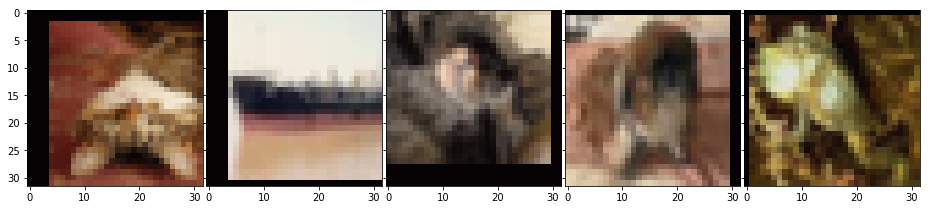

In [37]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.05)    
for i in range(5):
    ax = grid[i]
    imshow(ax, img[i])
    #ax.imshow(img[i].numpy().transpose((1, 2, 0)))
    

# Use pretrained model

In [9]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloaders['train'].dataset), 
                     'valid': len(dataloaders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        tqdm.write('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [10]:
def freezeAllLayersTillN(model, n):
    c = 0
    for child in model.children():
        c += 1
        if c < n:
            for param in child.parameters():
                param.requires_grad = False
                
def freezeAllLayers(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = False
                
def unfreezeAllLayers(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True

In [11]:
arch = SENet18()
arch.cuda();

In [12]:
X, Y = next(iter(train_dl))
X, Y = Variable(X.cuda(), volatile=True), Variable(Y.cuda(), volatile=True)
print(X.size())
outputs = arch(X)
print(outputs.size())

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


torch.Size([128, 3, 32, 32])
torch.Size([128, 10])


In [13]:
p = f'{PATH}weights/sen_32x32_8.h5'
pretrained_weights = torch.load(p, map_location=lambda storage, loc: storage)

In [14]:
arch.load_state_dict(pretrained_weights)

In [18]:
freezeAllLayersTillN(arch, 7)

In [19]:
lr = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, arch.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
dloaders = {'train':train_dl, 'valid':valid_dl}

In [20]:
start_time = time.time()
model = train_model(dloaders, arch, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [0/1] train loss: 0.0004 acc: 0.9849 valid loss: 0.0003 acc: 0.9899


100%|██████████| 79/79 [00:02<00:00, 39.21it/s]

Epoch [1/1] train loss: 0.0004 acc: 0.9843 valid loss: 0.0003 acc: 0.9897
Best val Acc: 0.989900
Training time:   2.537394 minutes


# Modify Model Layers

In [34]:
new = nn.Sequential(*list(arch.children())[:-1])
replaced = nn.Sequential(new, nn.Linear(512, 10))

Running the cell block will raise sizes mismatch error

In [ ]:
replaced.cuda()
X, Y = next(iter(train_dl))
X, Y = Variable(X.cuda()), Variable(Y.cuda())
outputs = replaced(X)

print(X.size(), out.size())

Examine the output size of fc2 in layer4. It's 512x4x4 and it would not match the input size of next linear layer. Taking a look at the SENet's source code, we found out that the model using functions from nn.Functional instead of nn.modules for adaptive_max_pool2d/log_softmax layers. Functions from nn.Functional won't show up in the model summary.

In [22]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [23]:
featureLayer = nn.Sequential(OrderedDict(arch._modules))
featureLayer._modules.pop('linear', None)
featureLayer._modules.update({'AdaptiveMaxPool2d': nn.AdaptiveMaxPool2d(1)})
featureLayer._modules.move_to_end('AdaptiveMaxPool2d')
featureLayer.load_state_dict({k: v for k, v in pretrained_weights.items() if k in featureLayer.state_dict()}) #filter out keys not in feature layers

classiferLayer = nn.Sequential(nn.Linear(512, 10), nn.LogSoftmax(1))

newModel = nn.Sequential(OrderedDict([('feature', featureLayer),
                                       ('flatten', Flatten()),
                                       ('classifier', classiferLayer)]))

In [24]:
#Test the new layers
newModel.cuda()

X, Y = next(iter(train_dl))
X, Y = Variable(X.cuda(), volatile=True), Variable(Y.cuda(), volatile=True)
out = newModel(X)

print(X.size(), out.size())

torch.Size([128, 3, 32, 32]) torch.Size([128, 10])


In [25]:
freezeAllLayers(newModel.feature)
freezeAllLayers(newModel.flatten)
unfreezeAllLayers(newModel.classifier)

In [26]:
lr = 1e-3
newModel.cuda()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, newModel.parameters()), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
dloaders = {'train':train_dl, 'valid':valid_dl}

In [27]:
start_time = time.time()
newModel = train_model(dloaders, newModel, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [0/1] train loss: 0.0052 acc: 0.9374 valid loss: 0.0019 acc: 0.9866


100%|██████████| 79/79 [00:02<00:00, 39.25it/s]

Epoch [1/1] train loss: 0.0018 acc: 0.9820 valid loss: 0.0012 acc: 0.9871
Best val Acc: 0.987100
Training time:   0.321077 minutes


## Switch the last layer by direct modification of the OrderedDict

In [28]:
print(newModel._modules['classifier'])

Sequential(
  (0): Linear(in_features=512, out_features=10, bias=True)
  (1): LogSoftmax()
)


In [29]:
newModel._modules['classifier'] = nn.Sequential(nn.Linear(512, 2), nn.LogSoftmax(1))
print(newModel._modules['classifier'])

Sequential(
  (0): Linear(in_features=512, out_features=2, bias=True)
  (1): LogSoftmax()
)


## Grab 2 class from another dataset

In [30]:
ap_data_path = '/data/cifar100/apple_pear'
ap_csv_path = '/data/cifar100/apple_pear.csv'

In [31]:
df_ap = pd.read_csv(ap_csv_path)
df_ap = df_ap.drop('coarse_labels', 1)

In [32]:
df_ap = df_ap.rename(columns={'filenames': 'id', 'fine_labels': 'label'})

In [33]:
df_ap.id = df_ap['id'].apply(lambda x: str(x).rstrip('.png'))

In [34]:
sz = 32
bs = 128

df_ap_train = df_ap.sample(frac=0.8,random_state=200)
df_ap_valid = df_ap.drop(df_ap_train.index)

train_ds = CIFARDataset(df_ap_train, ap_data_path, transform=getTransforms(sz, mean, std, aug=True))
valid_ds = CIFARDataset(df_ap_valid, ap_data_path, transform=getTransforms(sz, mean, std))

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=4)

len(df_ap_train), len(df_ap_valid)

(960, 240)

Freeze the early feature layers because we would want to utilized features learned from the cifar10 dataset

In [80]:
#freeze all llayer but the classifier
freezeAllLayers(newModel.feature)
freezeAllLayers(newModel.flatten)
unfreezeAllLayers(newModel.classifier)

#unfreezeAllLayers(newModel)

In [81]:
lr = 1e-2
newModel.cuda()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, newModel.parameters()), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
dloaders = {'train':train_dl, 'valid':valid_dl}

In [83]:
start_time = time.time()
newModel = train_model(dloaders, newModel, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [0/9] train loss: 0.0002 acc: 0.9969 valid loss: 0.0020 acc: 0.9208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/9] train loss: 0.0002 acc: 0.9906 valid loss: 0.0020 acc: 0.9208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/9] train loss: 0.0003 acc: 0.9906 valid loss: 0.0020 acc: 0.9208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/9] train loss: 0.0002 acc: 0.9948 valid loss: 0.0020 acc: 0.9208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/9] train loss: 0.0002 acc: 0.9979 valid loss: 0.0020 acc: 0.9208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/9] train loss: 0.0003 acc: 0.9948 valid loss: 0.0021 acc: 0.9208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/9] train loss: 0.0002 acc: 0.9958 valid loss: 0.0021 acc: 0.9208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/9] train loss: 0.0002 acc: 0.9979 valid loss: 0.0020 acc: 0.9208


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/9] train loss: 0.0002 acc: 0.9979 valid loss: 0.0020 acc: 0.9208


100%|██████████| 2/2 [00:00<00:00, 11.00it/s]

Epoch [9/9] train loss: 0.0002 acc: 0.9938 valid loss: 0.0020 acc: 0.9208
Best val Acc: 0.920833
Training time:   0.086916 minutes
